In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
from utils import ALL_LETTERS, N_LETTERS
from utils import load_data, letter_to_tensor, line_to_tensor, random_training_example

In [3]:
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self,input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor),1)

        hidden = self.i2h(combined)
        output = self.i2o(combined)

        output = self.softmax(output)

        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [4]:
category_lines, all_categories = load_data()
n_categories = len(all_categories)
print(n_categories)

18


In [5]:
n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)

In [6]:
# one step

input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor, hidden_tensor)

print(output)

tensor([[-2.9528, -2.9084, -2.9588, -2.9157, -2.8804, -2.8523, -2.7647, -2.9132,
         -2.9430, -2.8629, -2.8885, -2.7992, -2.9083, -2.9012, -2.9527, -2.8603,
         -2.8514, -2.9370]], grad_fn=<LogSoftmaxBackward0>)


In [7]:
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()

output, next_tensor = rnn(input_tensor[0], hidden_tensor)
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [8]:
# whole sequence 
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()

output, next_tensor = rnn(input_tensor[0], hidden_tensor)
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [9]:
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

print(category_from_output(output))

Russian


In [10]:
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [11]:
def train(line_tensor,category_tensor):
    hidden = rnn.init_hidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i],hidden)

    loss = criterion(output, category_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()

In [16]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000

for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    output,loss = train(line_tensor, category_tensor)
    current_loss += loss

    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0

    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print(f"{i} {i/n_iters*100} {loss:.4f} {line} / {guess} {correct}")


4999 4.999 2.6710 Klerkse / French ✗ (Dutch)
9999 9.998999999999999 2.2266 Matos / Greek ✗ (Portuguese)
14999 14.999 1.4208 Daly / Irish ✓
19999 19.999 1.0381 Alvarez / Spanish ✓
24999 24.999 1.6093 Liao / Vietnamese ✗ (Chinese)
29999 29.999 1.5393 Madden / Dutch ✗ (Irish)
34999 34.999 1.0223 Lao / Vietnamese ✗ (Chinese)
39999 39.999 1.1929 Ding / Vietnamese ✗ (Chinese)
44999 44.999 0.2476 Byon / Korean ✓
49999 49.999 0.9197 Adler / German ✓
54999 54.998999999999995 0.7850 Phan / Vietnamese ✓
59999 59.999 0.1100 Campbell / Scottish ✓
64999 64.999 2.3320 Clarke / Polish ✗ (English)
69999 69.999 0.4489 Luu / Vietnamese ✓
74999 74.99900000000001 0.9147 Kasprzak / Czech ✗ (Polish)
79999 79.999 2.3571 Kouches / Dutch ✗ (Greek)
84999 84.999 0.3888 Bohler / German ✓
89999 89.999 2.2906 Molina / Irish ✗ (Spanish)
94999 94.999 0.4170 Hanraets / Dutch ✓
99999 99.99900000000001 5.2639 Auttenberg / German ✗ (Polish)


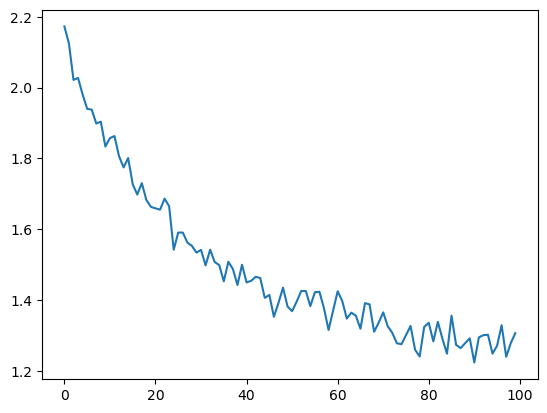

In [18]:
plt.figure()
plt.plot(all_losses)
plt.show()

In [19]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        
        hidden = rnn.init_hidden()
    
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        
        guess = category_from_output(output)
        print(guess)


In [26]:
predict("Khan")


> Khan
Scottish
